In [1]:
from sqlalchemy import create_engine
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats.mstats import winsorize
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

cars_df=pd.read_csv('/Users/steveangeli/Downloads/vehicles.csv')
cars_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [2]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
id              509577 non-null int64
url             509577 non-null object
region          509577 non-null object
region_url      509577 non-null object
price           509577 non-null int64
year            508050 non-null float64
manufacturer    486813 non-null object
model           501588 non-null object
condition       277643 non-null object
cylinders       309894 non-null object
fuel            505592 non-null object
odometer        417253 non-null float64
title_status    506515 non-null object
transmission    505858 non-null object
vin             302152 non-null object
drive           365434 non-null object
size            167574 non-null object
type            368046 non-null object
paint_color     344871 non-null object
image_url       509563 non-null object
description     509561 non-null object
county          0 non-null float64
state           509577 non-null obj

In [3]:
# Drop some columns that I don't believe wil have much impact on the sale price or that have big problems.
cars_df.drop(columns=['url', 'model', 'region_url', 'vin', 'image_url', 'description', 'county', 'lat', 'long'], inplace=True)

In [4]:
# Drop any null rows because I still should have plenty of data to work with. 

cars_df.dropna(inplace=True)
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107938 entries, 0 to 509564
Data columns (total 16 columns):
id              107938 non-null int64
region          107938 non-null object
price           107938 non-null int64
year            107938 non-null float64
manufacturer    107938 non-null object
condition       107938 non-null object
cylinders       107938 non-null object
fuel            107938 non-null object
odometer        107938 non-null float64
title_status    107938 non-null object
transmission    107938 non-null object
drive           107938 non-null object
size            107938 non-null object
type            107938 non-null object
paint_color     107938 non-null object
state           107938 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 14.0+ MB


In [5]:
non_numeric_columns = cars_df.select_dtypes(['object']).columns
numeric_columns = cars_df.select_dtypes(['int64', 'float64']).columns

num_percent_missing = (cars_df[numeric_columns].isnull().sum()/cars_df[numeric_columns].isnull().count()).sort_values(ascending=False)
num_corr = np.abs(cars_df[numeric_columns].iloc[:,1:].corr().loc[:,"price"]).sort_values(ascending=False)
num_missing_data = pd.concat([num_percent_missing, num_corr], axis=1, keys=['Percent Missing', 'Correlation'])
num_missing_data = num_missing_data.sort_values(by='Correlation', ascending=False)
num_missing_data.head()

,Percent Missing,Correlation
price,0.0,1.000000
odometer,0.0,0.000781
year,0.0,0.000358
id,0.0,NaN


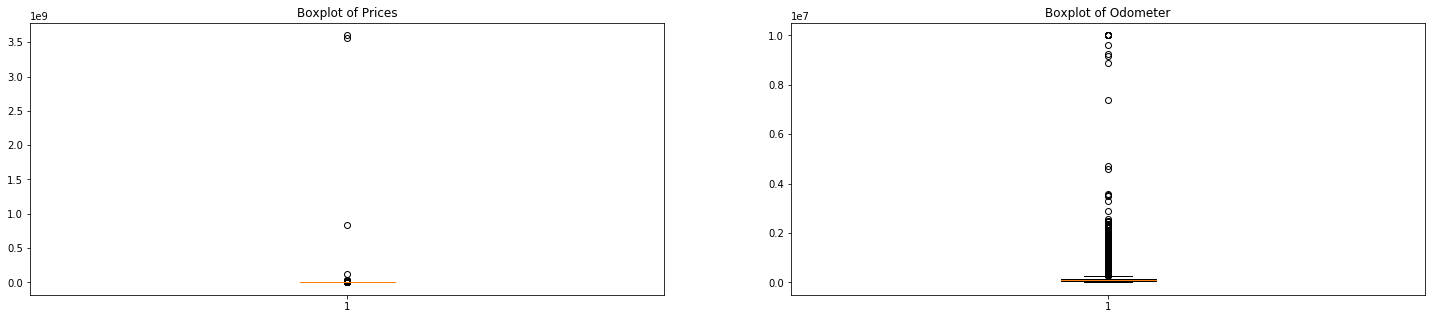

In [6]:
plt.figure(figsize=(25,5))

plt.subplot(1, 2, 1)
plt.boxplot(cars_df.price)
plt.title("Boxplot of Prices")

plt.subplot(1, 2, 2)
plt.boxplot(cars_df.odometer)
plt.title("Boxplot of Odometer")

plt.show()

In [7]:
# Dropping a couple of incorrect or unusual data entries.
mistakes_price = cars_df[cars_df['price'] > 100000].index
cars_df.drop(mistakes_price, inplace=True)

mistakes_price2 = cars_df[cars_df['price'] < 1000].index
cars_df.drop(mistakes_price2, inplace=True)

mistakes_year = cars_df[cars_df['year'] > 2019].index
cars_df.drop(mistakes_year, inplace=True)

mistakes_odom = cars_df[cars_df['odometer'] > 300000].index
cars_df.drop(mistakes_odom, inplace=True)

mistakes_odom2 = cars_df[cars_df['odometer'] < 5000].index
cars_df.drop(mistakes_odom2, inplace=True)

# Trimming down the years we're looking at to the past 15. 
cars_not_last_15 = cars_df[cars_df['year'] < 2004].index
cars_df.drop(cars_not_last_15, inplace=True)

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81194 entries, 0 to 509564
Data columns (total 16 columns):
id              81194 non-null int64
region          81194 non-null object
price           81194 non-null int64
year            81194 non-null float64
manufacturer    81194 non-null object
condition       81194 non-null object
cylinders       81194 non-null object
fuel            81194 non-null object
odometer        81194 non-null float64
title_status    81194 non-null object
transmission    81194 non-null object
drive           81194 non-null object
size            81194 non-null object
type            81194 non-null object
paint_color     81194 non-null object
state           81194 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 10.5+ MB


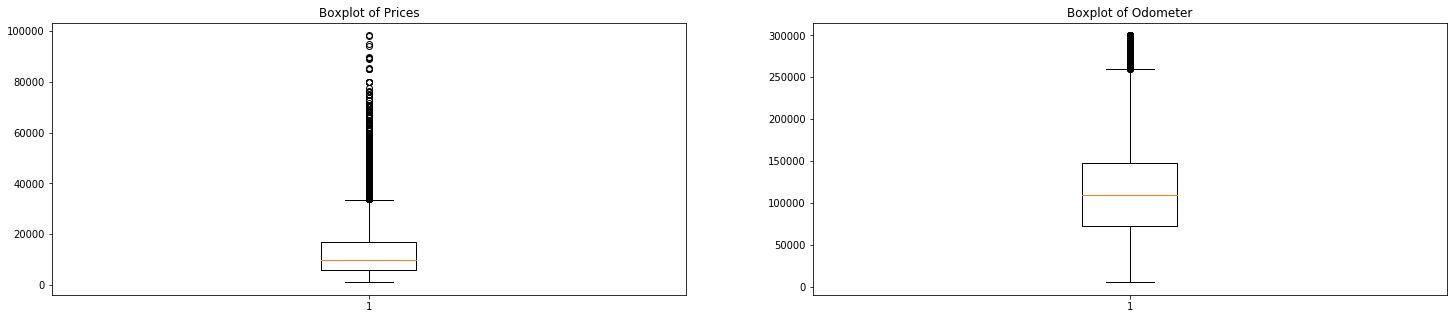

In [8]:
plt.figure(figsize=(25,5))

plt.subplot(1, 2, 1)
plt.boxplot(cars_df.price)
plt.title("Boxplot of Prices")

plt.subplot(1, 2, 2)
plt.boxplot(cars_df.odometer)
plt.title("Boxplot of Odometer")

plt.show()

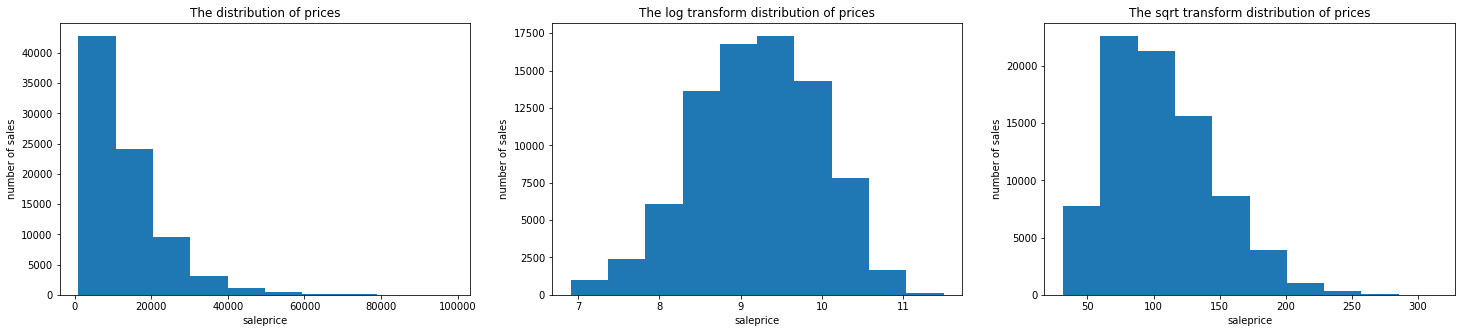

In [9]:
# price_boxcox, _ = stats.boxcox(cars_df.price)

plt.figure(figsize=(25,5))

plt.subplot(1, 3, 1)
plt.hist(cars_df.price)
plt.title("The distribution of prices")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

plt.subplot(1, 3, 2)
plt.hist(np.log1p(cars_df.price))
plt.title("The log transform distribution of prices")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

plt.subplot(1, 3, 3)
plt.hist(np.sqrt(cars_df.price))
plt.title("The sqrt transform distribution of prices")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

# plt.subplot(1, 4, 4)
# plt.hist(price_boxcox)
# plt.title("The boxcox transform distribution of prices")
# plt.xlabel("saleprice")
# plt.ylabel("number of sales")

plt.show()

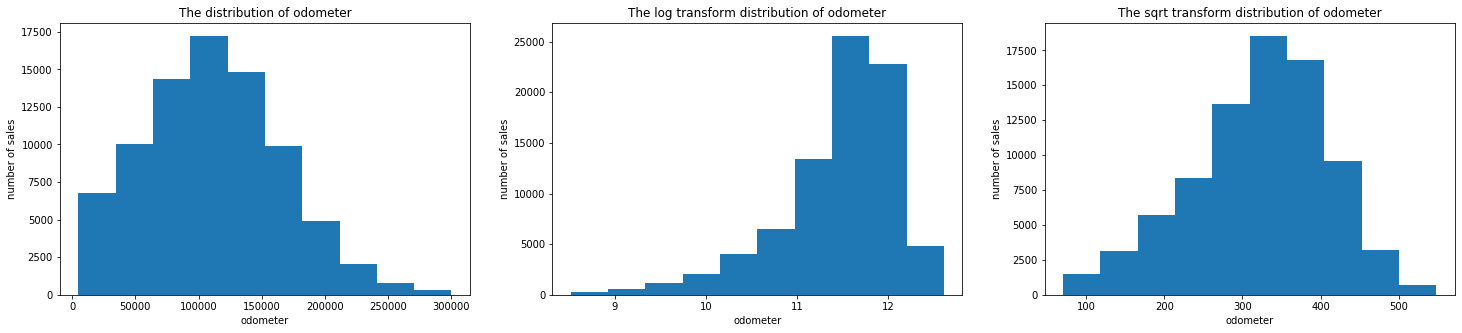

In [10]:
# odom_boxcox, _ = stats.boxcox(cars_df.odometer)

plt.figure(figsize=(25,5))

plt.subplot(1, 3, 1)
plt.hist(cars_df.odometer)
plt.title("The distribution of odometer")
plt.xlabel("odometer")
plt.ylabel("number of sales")

plt.subplot(1, 3, 2)
plt.hist(np.log1p(cars_df.odometer))
plt.title("The log transform distribution of odometer")
plt.xlabel("odometer")
plt.ylabel("number of sales")

plt.subplot(1, 3, 3)
plt.hist(np.sqrt(cars_df.odometer))
plt.title("The sqrt transform distribution of odometer")
plt.xlabel("odometer")
plt.ylabel("number of sales")

# plt.subplot(1, 4, 4)
# plt.hist(odom_boxcox)
# plt.title("The boxcox transform distribution of prices")
# plt.xlabel("saleprice")
# plt.ylabel("number of sales")

plt.show()

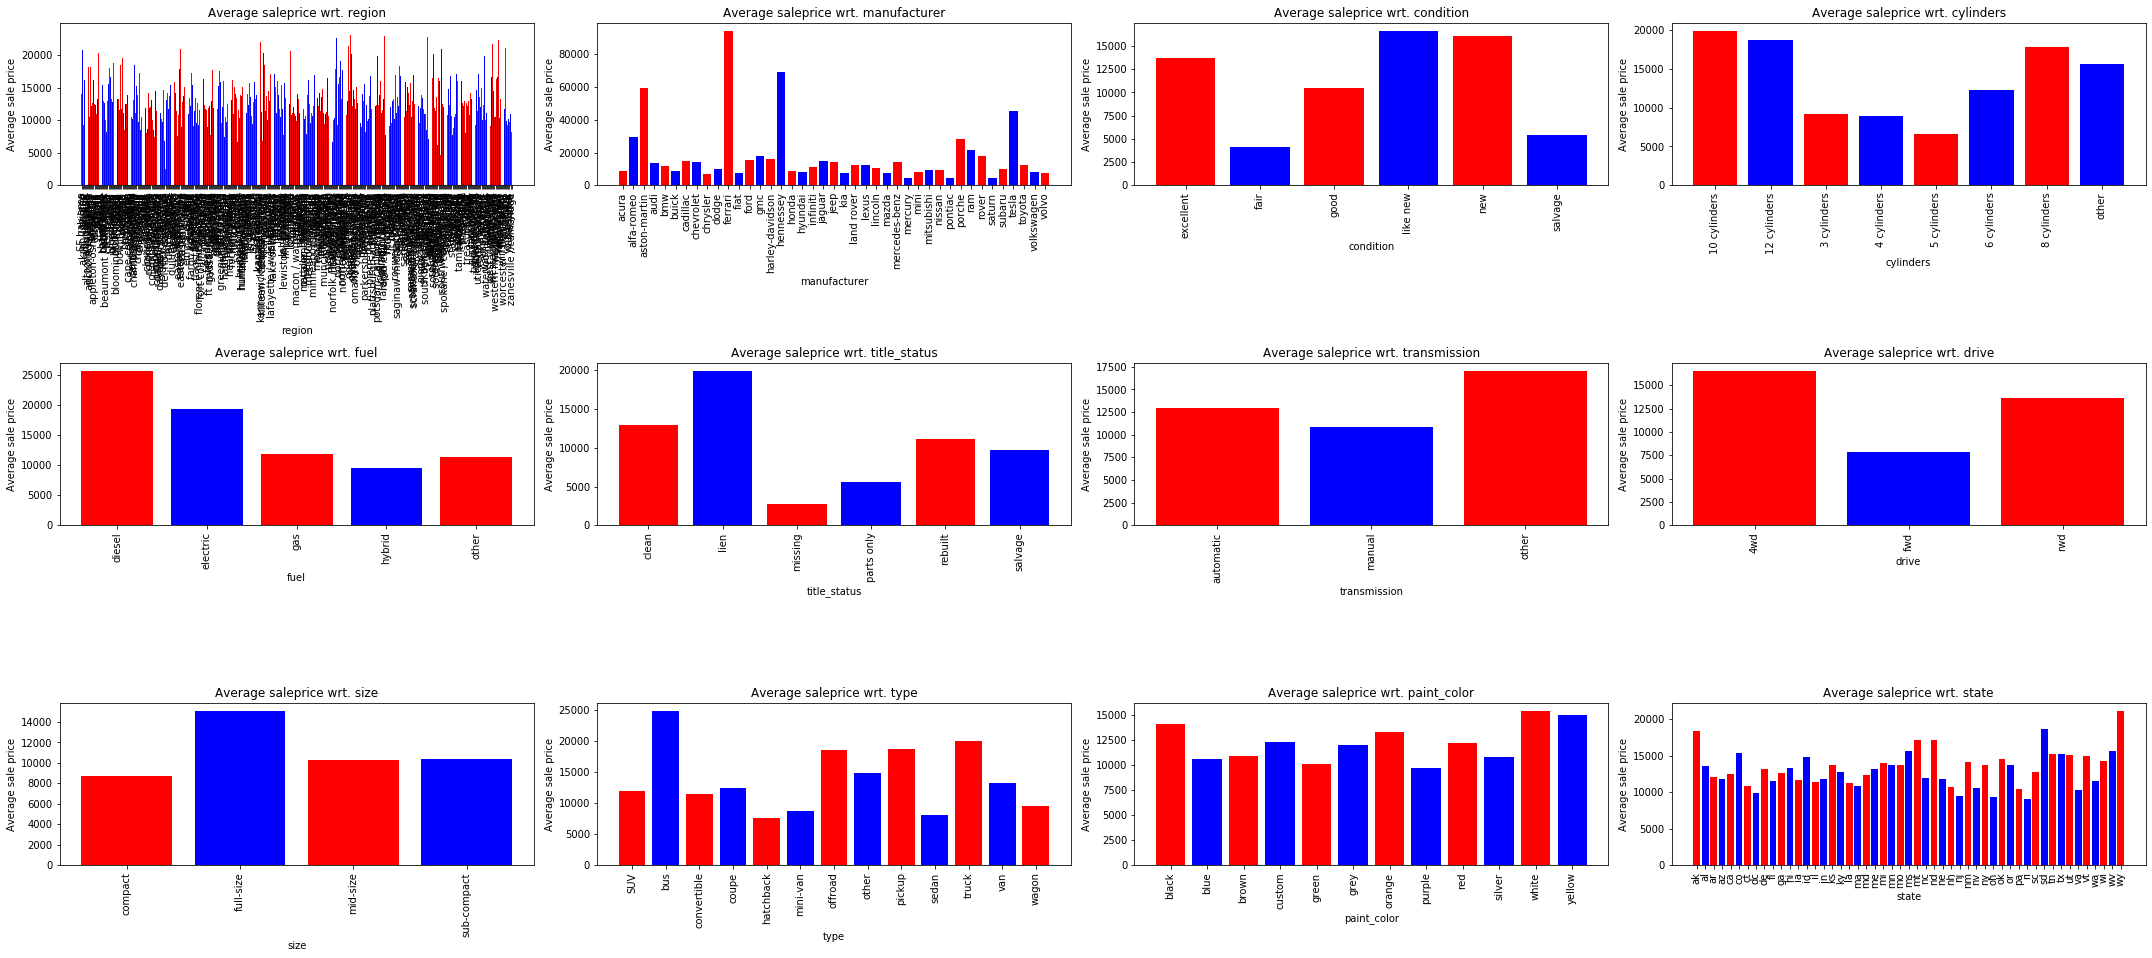

In [11]:
# Look into the categorical variables to see if there are any that show a lot of variance wrt saleprice.

plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(cars_df.groupby(column)["price"].mean().index, cars_df.groupby(column)["price"].mean(),
           color=("red","blue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [12]:
cars_df = pd.concat([cars_df,pd.get_dummies(cars_df.manufacturer, prefix="manufacturer", drop_first=True)], axis=1)
cars_df = pd.concat([cars_df,pd.get_dummies(cars_df.condition, prefix="condition", drop_first=True)], axis=1)
cars_df = pd.concat([cars_df,pd.get_dummies(cars_df.title_status, prefix="title_status", drop_first=True)], axis=1)
cars_df= pd.concat([cars_df,pd.get_dummies(cars_df.type, prefix="type", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(cars_df.manufacturer, prefix="manufacturer", drop_first=True).columns) + list(pd.get_dummies(cars_df.condition, prefix="condition", drop_first=True).columns) + list(pd.get_dummies(cars_df.title_status, prefix="title_status", drop_first=True).columns) + list(pd.get_dummies(cars_df.type, prefix="type", drop_first=True).columns)
print(dummy_column_names)

['manufacturer_alfa-romeo', 'manufacturer_aston-martin', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_ferrari', 'manufacturer_fiat', 'manufacturer_ford', 'manufacturer_gmc', 'manufacturer_harley-davidson', 'manufacturer_hennessey', 'manufacturer_honda', 'manufacturer_hyundai', 'manufacturer_infiniti', 'manufacturer_jaguar', 'manufacturer_jeep', 'manufacturer_kia', 'manufacturer_land rover', 'manufacturer_lexus', 'manufacturer_lincoln', 'manufacturer_mazda', 'manufacturer_mercedes-benz', 'manufacturer_mercury', 'manufacturer_mini', 'manufacturer_mitsubishi', 'manufacturer_nissan', 'manufacturer_pontiac', 'manufacturer_porche', 'manufacturer_ram', 'manufacturer_rover', 'manufacturer_saturn', 'manufacturer_subaru', 'manufacturer_tesla', 'manufacturer_toyota', 'manufacturer_volkswagen', 'manufacturer_volvo', 'condition_fair', 'condition_good', 'condition_like ne

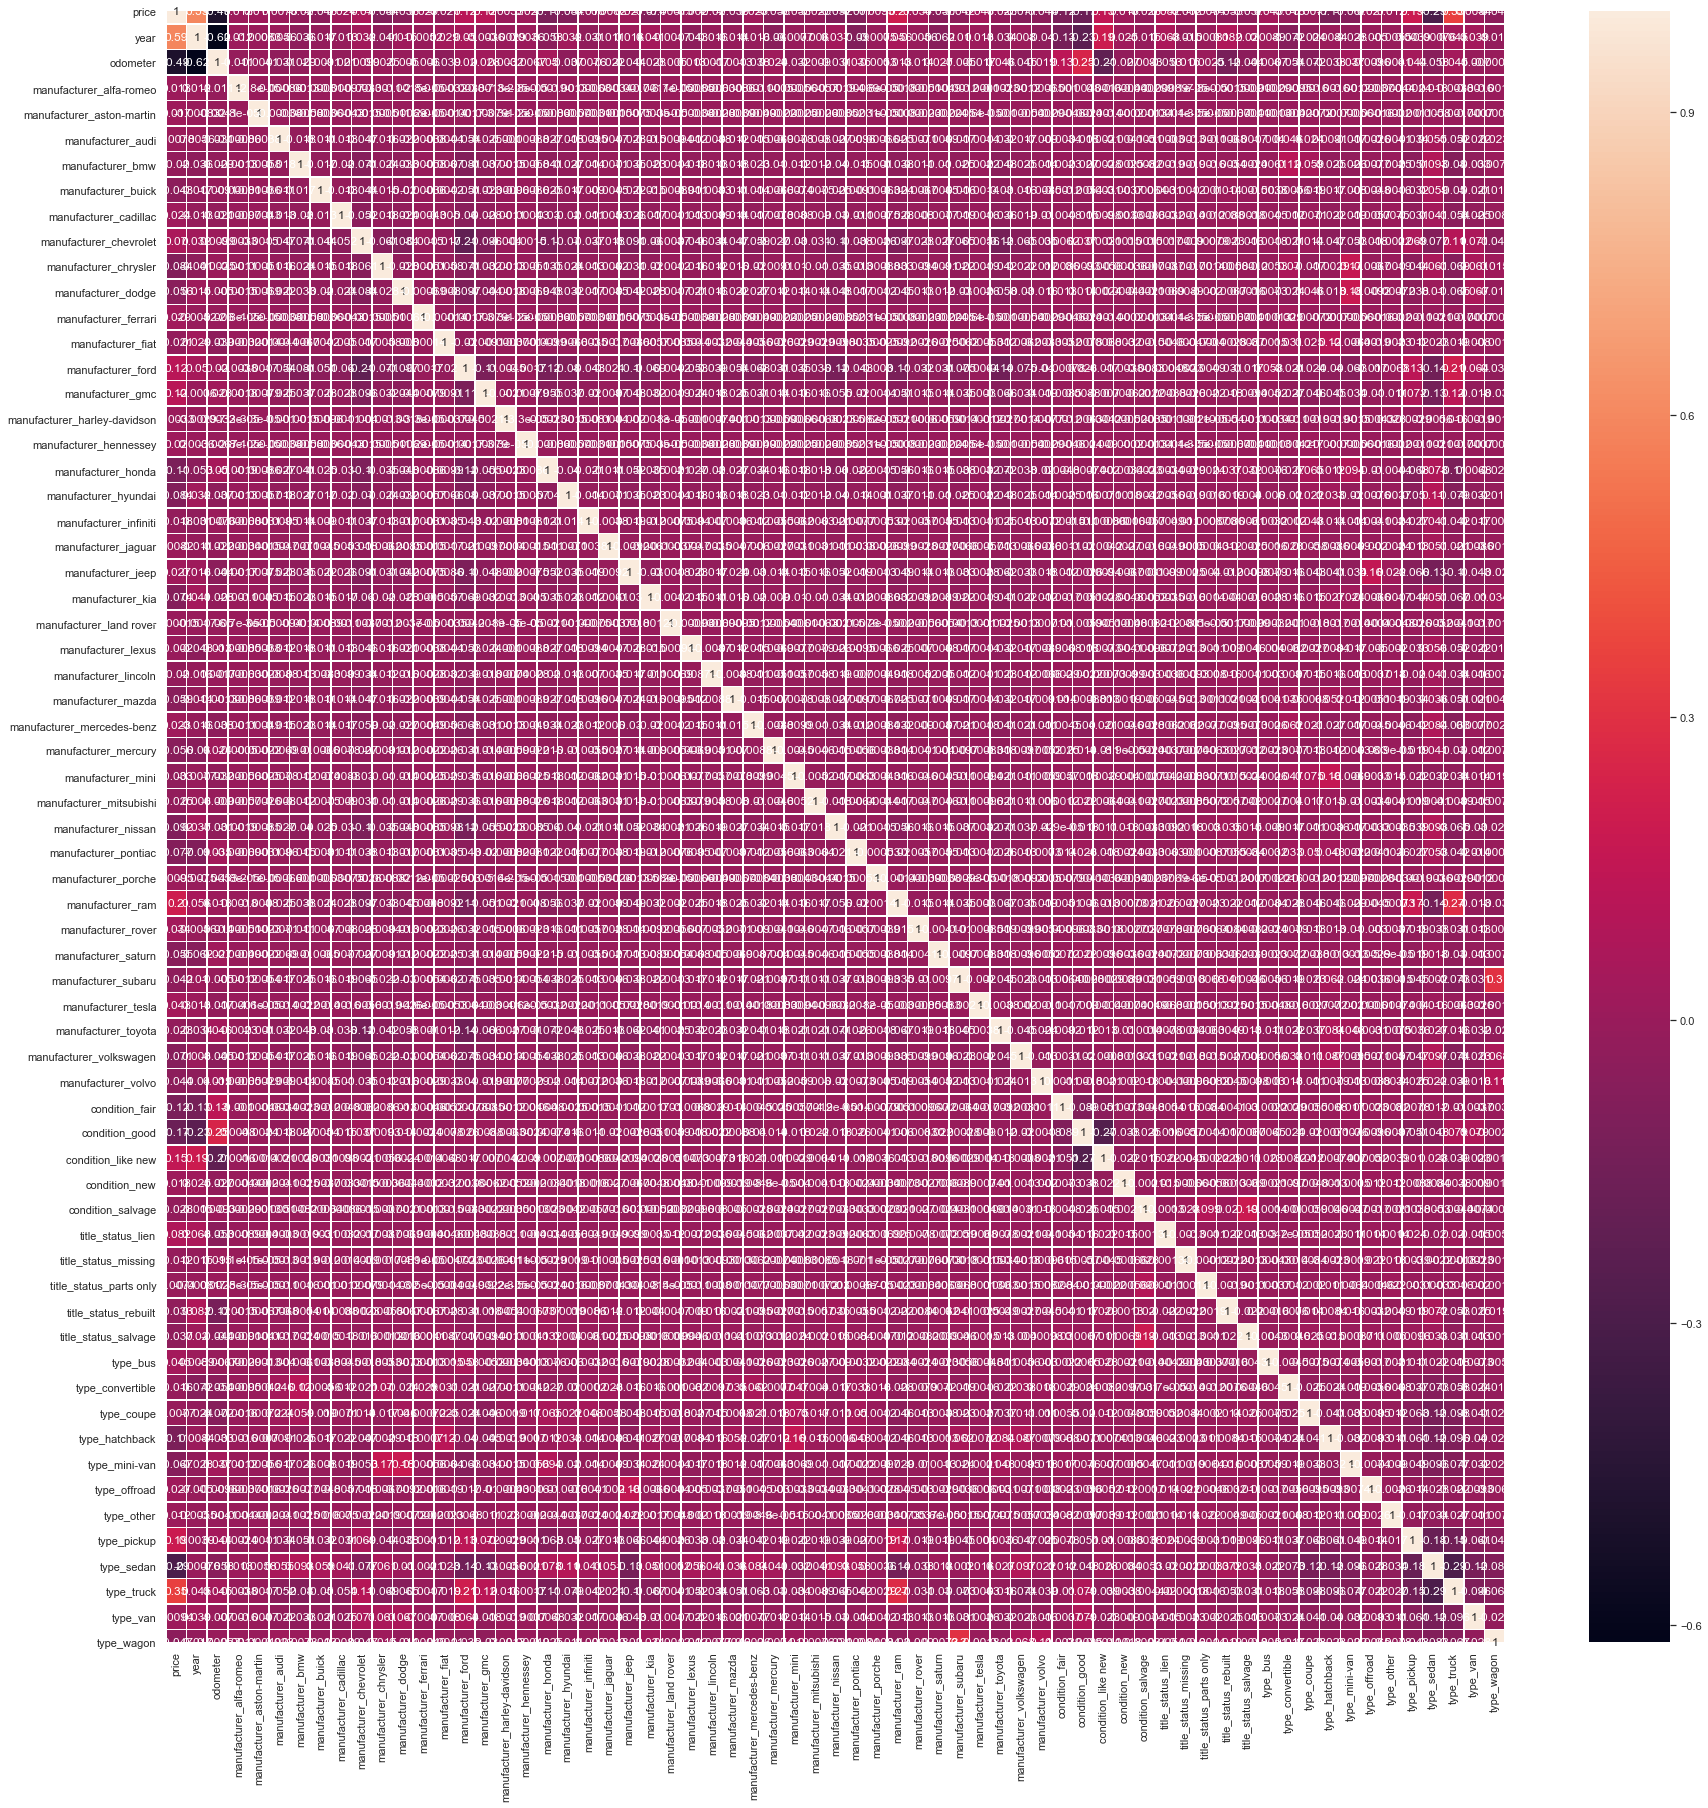

In [13]:
corrmat_cars = cars_df[['price', 'year', 'odometer'] + dummy_column_names].corr()

sns.set()
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrmat_cars, annot=True, linewidths=.5, ax=ax)
plt.show()

## Linear Regression Models

In [14]:
Y = np.log(cars_df['price'])
X = cars_df[['odometer', 'year'] + dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     2656.
Date:                Sat, 01 Feb 2020   Prob (F-statistic):               0.00
Time:                        09:57:54   Log-Likelihood:                -32785.
No. Observations:               64955   AIC:                         6.570e+04
Df Residuals:                   64891   BIC:                         6.628e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -157.1895      1.057   -148.774      0.000    -159.260    -155.119
odometer                     -3.809e-06   3.89e-08    -97.961      0.000   -3.89e-06   -3.73e-06
year                             0.0830      0.001    158.346      0.000       0.082       0.084
manufacturer_alfa-romeo          0.5701      0.201      2.833      0.005       0.176       0.964
manufacturer_aston-martin    -2.322e-10   6.51e-11     -3.568      0.000    -3.6e-10   -1.05e-10
manufacturer_audi                0.1660      0.022      7.570      0.000       0.123       0.209
manufacturer_bmw                 0.1136      0.019      5.962      0.000       0.076       0.151
manufacturer_buick              -0.1569      0.022     -7.031      0.000      -0.201      -0.113
manufacturer_cadillac            0.1941      0.021      9.347      0.000       0.153       0.235
manufacturer_chevrolet          -0.1286      0.017     -7.589      0.000      -0.162      -0.095
manufacturer_chrysler           -0.3070      0.020    -15.450      0.000      -0.346      -0.268
manufacturer_dodge              -0.2399      0.018    -13.064      0.000      -0.276      -0.204
manufacturer_ferrari             2.2616      0.402      5.631      0.000       1.474       3.049
manufacturer_fiat               -0.5707      0.043    -13.263      0.000      -0.655      -0.486
manufacturer_ford               -0.1572      0.017     -9.295      0.000      -0.190      -0.124
manufacturer_gmc                 0.0186      0.018      1.031      0.302      -0.017       0.054
manufacturer_harley-davidson    -0.0116      0.153     -0.076      0.939      -0.311       0.287
manufacturer_hennessey           1.1893      0.401      2.962      0.003       0.402       1.976
manufacturer_honda              -0.0946      0.018     -5.371      0.000      -0.129      -0.060
manufacturer_hyundai            -0.3538      0.019    -18.618      0.000      -0.391      -0.317
manufacturer_infiniti            0.1401      0.024      5.792      0.000       0.093       0.187
manufacturer_jaguar              0.3554      0.040      8.943      0.000       0.278       0.433
manufacturer_jeep               -0.0350      0.018     -1.923      0.055      -0.071       0.001
manufacturer_kia                -0.4431      0.020    -22.293      0.000      -0.482      -0.404
manufacturer_land rover         -0.4349      0.180     -2.414      0.016      -0.788      -0.082
manufacturer_lexus               0.3067      0.022     14.045      0.000       0.264       0.350
manufacturer_lincoln            -0.0063      0.026     -0.245      0.806      -0.056       0.044
manufacturer_mazda              -0.2748      0.022    -12.627      0.000      -0.318      -0.232
manufacturer_mercedes-benz       0.2484      0.020     12.478      0.000    

R-squared of the model in training set is: 0.7205733643725478


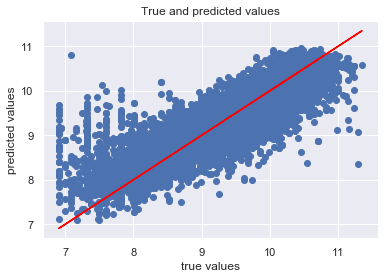

-----Test set statistics-----
R-squared of the model in the test set is: 0.7190868354683371
Mean absolute error of the prediction is: 0.2919065362918357
Mean squared error of the prediction is: 0.16113242584970008
Root mean squared error of the prediction is: 0.40141303647203597
Mean absolute percentage error of the prediction is: 3.22620152720796
-----Linear Assumption Tests-----
Mean of the errors is: 0.001709823770218052
Bartlett test statistic value is 17599.6 and p value is 0
Levene test statistic value is 19959.1 and p value is 0


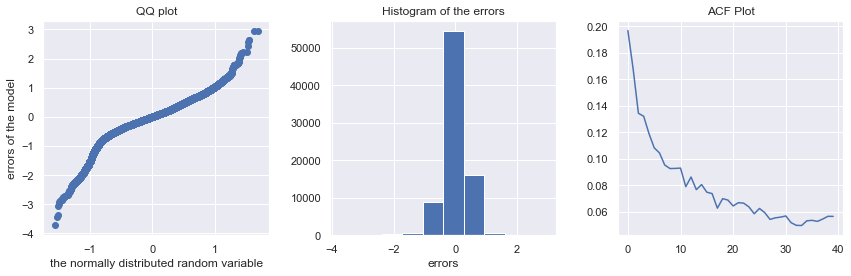

In [15]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lrm.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7205733643725438


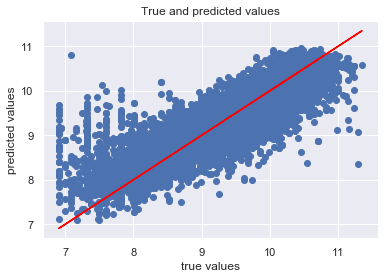

-----Test set statistics-----
R-squared of the model on the test set is: 0.7190868353462727
Mean absolute error of the prediction is: 0.29190653657281634
Mean squared error of the prediction is: 0.16113242591971647
Root mean squared error of the prediction is: 0.40141303655924837
Mean absolute percentage error of the prediction is: 3.226201530974003
-----Linear Assumption Tests-----
Mean of the errors is: 0.0017098237256255133
Bartlett test statistic value is 17599.6 and p value is 0
Levene test statistic value is 19959.1 and p value is 0


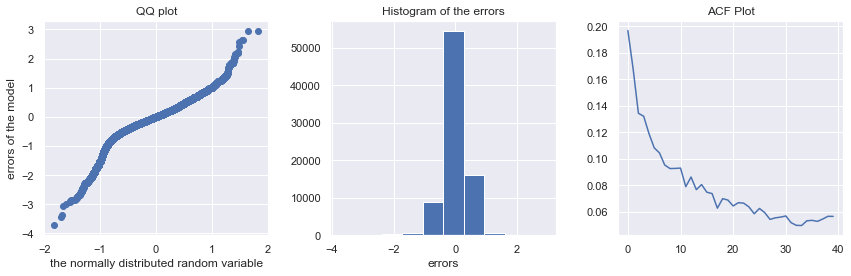

In [16]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lasso_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 0.1
R-squared of the model in training set is: 0.7205717887163448


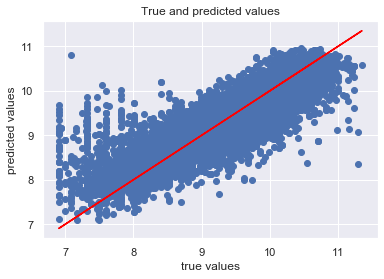

-----Test set statistics-----
R-squared of the model on the test set is: 0.7190873640796196
Mean absolute error of the prediction is: 0.29190542232421907
Mean squared error of the prediction is: 0.1611321226370742
Root mean squared error of the prediction is: 0.40141265879027055
Mean absolute percentage error of the prediction is: 3.226193841812185
-----Linear Assumption Tests-----
Mean of the errors is: 0.0017087949221083441
Bartlett test statistic value is 17596.4 and p value is 0
Levene test statistic value is 19958.4 and p value is 0


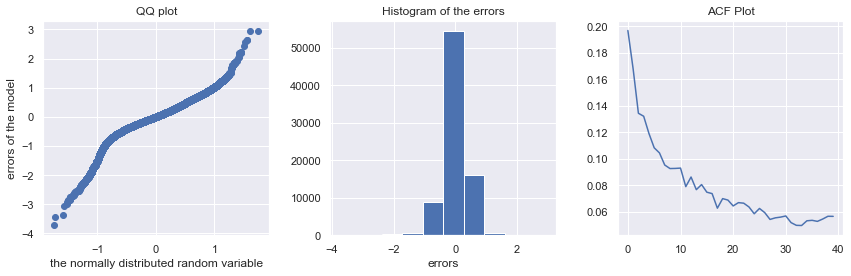

In [17]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = ridge_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7205733643725424


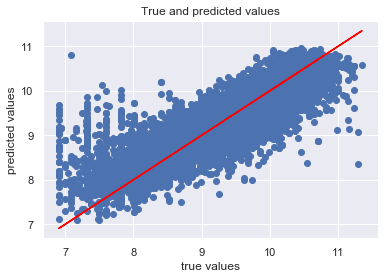

-----Test set statistics-----
R-squared of the model on the test set is: 0.7190868354310321
Mean absolute error of the prediction is: 0.2919065363828707
Mean squared error of the prediction is: 0.1611324258710983
Root mean squared error of the prediction is: 0.4014130364986896
Mean absolute percentage error of the prediction is: 3.226201528713231
-----Linear Assumption Tests-----
Mean of the errors is: 0.001709823711352407
Bartlett test statistic value is 17599.6 and p value is 0
Levene test statistic value is 19959.1 and p value is 0


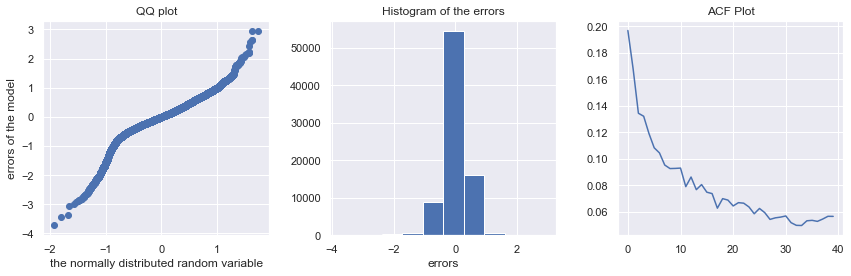

In [18]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = elasticnet_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

## KNN Model

In [19]:
cars_df2 = pd.DataFrame()
cars_df2 = cars_df[['price', 'odometer', 'year'] + dummy_column_names]
cars_df2['log_price'] = np.log(cars_df2['price'])
cars_df2.drop(columns=['price'], inplace=True)

cars_df2.info()

mm_scaler = preprocessing.MinMaxScaler()
scaled_cars = mm_scaler.fit_transform(cars_df2)
scaled_cars_df = pd.DataFrame(scaled_cars, columns=cars_df2.columns)
scaled_cars_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81194 entries, 0 to 509564
Data columns (total 65 columns):
odometer                        81194 non-null float64
year                            81194 non-null float64
manufacturer_alfa-romeo         81194 non-null uint8
manufacturer_aston-martin       81194 non-null uint8
manufacturer_audi               81194 non-null uint8
manufacturer_bmw                81194 non-null uint8
manufacturer_buick              81194 non-null uint8
manufacturer_cadillac           81194 non-null uint8
manufacturer_chevrolet          81194 non-null uint8
manufacturer_chrysler           81194 non-null uint8
manufacturer_dodge              81194 non-null uint8
manufacturer_ferrari            81194 non-null uint8
manufacturer_fiat               81194 non-null uint8
manufacturer_ford               81194 non-null uint8
manufacturer_gmc                81194 non-null uint8
manufacturer_harley-davidson    81194 non-null uint8
manufacturer_hennessey          81194 

,odometer,year,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,...,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,log_price
0,0.198305,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.628739
1,0.359261,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.332608
2,0.211349,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.726264
3,0.420339,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.199708
4,0.203390,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.541593


R-squared of the model in training set is: 0.8805269791400984
R-squared of the model on the test set is: 0.7476022984290103


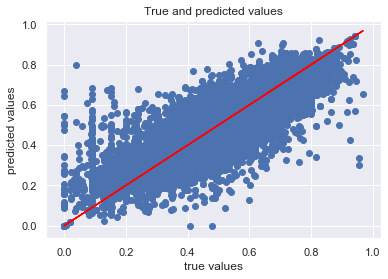

In [20]:
from sklearn import neighbors

# Build our model.

knn = neighbors.KNeighborsRegressor(n_neighbors=3)
X = scaled_cars_df[['odometer', 'year'] + dummy_column_names]
Y = scaled_cars_df.log_price

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

knn.fit(X_train, y_train)

y_preds_train = knn.predict(X_train)
y_preds_test = knn.predict(X_test)

print("R-squared of the model in training set is: {}".format(knn.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(knn.score(X_test, y_test)))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

R-squared of the model in training set is: 0.9961997949095496
R-squared of the model on the test set is: 0.7613334463850729


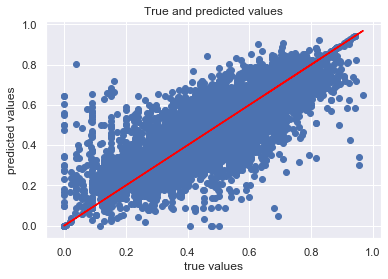

In [21]:
# Run the same model, this time with weights.

knn_w = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance')
X = scaled_cars_df[['odometer', 'year'] + dummy_column_names]
Y = scaled_cars_df.log_price

knn_w.fit(X_train, y_train)

y_preds_train = knn_w.predict(X_train)
y_preds_test = knn_w.predict(X_test)

print("R-squared of the model in training set is: {}".format(knn_w.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(knn_w.score(X_test, y_test)))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.68 (+/- 0.05)
Weighted Accuracy: 0.67 (+/- 0.06)


## Summary

### Comparing Models:

Both models performed similarly, but the highest performer was the weighted KNN model.

### Problems with the Data:
The data set I used pulled over 500,000 listings for used cars from Craigslist. Craigslist is not known for being the most realiable/accurate source for data. People often make typos, over-estimate the value of their product, incorrectly label information, etc. I attempted to clean it up by removing outlier data and using transformations. There is also a built in variance in the value of a used car, it is somewhat subjective, which leads to an additional source of variance.  